In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# (1) Data understanding and prep:

The original dataset from CDC has been cleaned and exported as file cleaned-covid19-merged.csv. And is now imported as a starting point for this work.

1. The accompanying data quality report from Task1 can be found attached as PDF as a background to this cleaned dataset;
2. A summary of this plan can be seen in the table below;
3. In addition a number of extra features were added (to to better capture the problem domain) that were not in the original dataset.
    - res_region: Groups the states into five regions of the United States. N - North East W - West M - Mid West S - South O - Other
    - elderly_yn: Indicate whether a patient is 65 years old or older.
    - season: Classify the case_month feature into seasons.

### Summary of data quality plan:

A potential data quality plan lists all features and actions involving those features:

    
| Feature                 | Data Quality Issue         | Handling Strategy         |
|-------------------------|----------------------      |------------------------   |
|case_month (category)                          |   none| Keep as is.|
res_state (category)             | 1 null value  | replace null values of feature res_county with the most frequent county name. For later readability, can keep a dictionary mapping state code to state name.       
state_fips_code (category)       | 6% null values | Drop the feature as it describe the same thing as res_state.|
res_county (category)             | Missing Values (6.42%)       | Drop column as it is like a duplicate feature to county_fips_code and it is not a unique identifier   | 
county_fips_code (category)                 | Missing Values (6.42%) | Check if possible to fill null value using res_county|  
age_group (category)                | Missing Values (0.99%) | Convert null to missing, and take missing values into account when analysing data.|
sex (category)    | Missing Values (2.84%) | Convert null to missing, and take missing values into account when analysing data.|
race (category)                  | Missing Values (24.09%) | Convert null to missing, and take missing values into account when analysing data.|
ethnicity (category)                 | Missing Values (31.46%) | Convert null to missing, and take missing values into account when analysing data. |    
case_positive_specimen_interval (int64)                    | Missing Values（47.07%)| Drop column as this feature has little effect on target outcome |   
case_positive_specimen_interval (int64)                    |           Failure of Logical integrity checks (negative values)| Drop column as this feature has little effect on target outcome |   
case_onset_interval (int64)             | Missing values (55.22%) | Drop column as this feature has little effect on target outcome |
case_onset_interval (int64)                    |            Failure of Logical integrity checks (negative values)| Drop column as this feature has little effect on target outcome |   
process (category)               | Missing values (91.16%) | Drop column as this feature has little effect on target outcome and has most values missing.|
exposure_yn                (category) |Irregular Cardinality (1)  | Constant column, drop feature|
current_status (category)         | None | Keep as is|
symptom_status (category)         | Missing values (51.26%) | Although with many missing values, the feature is very important and may affect the following analysis. Would derive an new feature with missing values. |
hosp_yn                 (category) |Missing values (33.13%)  | Investigate rows where this value appears, would derive an new feature with missing values.|
icu_yn                 (category) |Missing values (91.46%)  | Convert unknown and null to missing, and take missing values into account when analysing data|
death_yn                 (category) |None  | Keep as is|
underlying_conditions_yn                (category) |Missing values (91.19%)  | Convert null to missing, and take missing values into account when analysing data|

##  1.1 Review, prepare and split the dataset into two datasets: 70% training and 30% test
Here we will import cleaned dataset

In [2]:
# read in the cleaned csv
df = pd.read_csv('cleaned-covid19-1_2-merged.csv', keep_default_na=True,  delimiter=',', skipinitialspace=True, encoding='Windows-1252')
df.head(5)

,case_month,res_state,county_fips_code,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,res_region,elderly_yn,season
0,2020-12-01,SC,45083.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,unknown,Yes,missing,Yes,missing,S,True,Winter
1,2021-08-01,FL,12086.0,65+ years,Male,White,Hispanic/Latino,Laboratory-confirmed case,unknown,No,missing,Yes,missing,S,True,Summer
2,2021-01-01,RI,44007.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,unknown,missing,missing,Yes,missing,N,True,Winter
3,2021-01-01,CA,6073.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,missing,Yes,missing,W,True,Winter
4,2020-12-01,PA,42007.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Yes,No,Yes,Yes,N,True,Winter


After importing the cleaned csv, as a reminder we will check the shape, inspect the datatypes and check for any remaining null values

In [3]:
df.shape

(39893, 16)

In [4]:
df.dtypes

case_month                   object
res_state                    object
county_fips_code            float64
age_group                    object
sex                          object
race                         object
ethnicity                    object
current_status               object
symptom_status               object
hosp_yn                      object
icu_yn                       object
death_yn                     object
underlying_conditions_yn     object
res_region                   object
elderly_yn                     bool
season                       object
dtype: object

In [5]:
df.isna().sum()

case_month                  0
res_state                   0
county_fips_code            0
age_group                   0
sex                         0
race                        0
ethnicity                   0
current_status              0
symptom_status              0
hosp_yn                     0
icu_yn                      0
death_yn                    0
underlying_conditions_yn    0
res_region                  0
elderly_yn                  0
season                      0
dtype: int64

In [6]:
print("unique value for case_month is: " + df['case_month'].unique())
print("unique value for res_state is: " + df['res_state'].unique())
print("unique value for county_fips_code is: " + str(df['county_fips_code'].unique()))
print("unique value for age_group is: " + df['age_group'].unique())
print("unique value for sex is: " + df['sex'].unique())
print("unique value for race is: " + df['race'].unique())
print("unique value for ethnicity is: " + df['ethnicity'].unique())
print("unique value for current_status is: " + df['current_status'].unique())
print("unique value for symptom_status is: " + df['symptom_status'].unique())
print("unique value for hosp_yn is: " + df['hosp_yn'].unique())
print("unique value for icu_yn is: " + df['icu_yn'].unique())
print("unique value for death_yn is: " + df['death_yn'].unique())
print("unique value for underlying_conditions_yn is: " + df['underlying_conditions_yn'].unique())
print("unique value for res_region is: " + df['res_region'].unique())
print("unique value for elderly_yn is: " + str(df['elderly_yn'].unique()))
print("unique value for season is: " + df['season'].unique())

['unique value for case_month is: 2020-12-01'
 'unique value for case_month is: 2021-08-01'
 'unique value for case_month is: 2021-01-01'
 'unique value for case_month is: 2021-03-01'
 'unique value for case_month is: 2021-10-01'
 'unique value for case_month is: 2020-04-01'
 'unique value for case_month is: 2021-11-01'
 'unique value for case_month is: 2020-06-01'
 'unique value for case_month is: 2021-12-01'
 'unique value for case_month is: 2020-03-01'
 'unique value for case_month is: 2021-09-01'
 'unique value for case_month is: 2022-01-01'
 'unique value for case_month is: 2021-02-01'
 'unique value for case_month is: 2020-07-01'
 'unique value for case_month is: 2020-11-01'
 'unique value for case_month is: 2021-04-01'
 'unique value for case_month is: 2021-07-01'
 'unique value for case_month is: 2022-06-01'
 'unique value for case_month is: 2020-09-01'
 'unique value for case_month is: 2020-05-01'
 'unique value for case_month is: 2020-08-01'
 'unique value for case_month is: 

#### Convert datatypes for plotting later
We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- The target feature "death_yn" is type object, with values "yes" & "no". These will be mapped 'yes': 1, "no": 0 and stored as "int64"
- Categorical features "elderly_yn" is boolean False/True values. These will be converted to "int64" with value of 0,1
- Convert type of 'county_fips_code' as 'object', this can be converted to 'category'.
- The feature "hops_yn" is type object, with values "yes" & "no". These will be mapped 'yes': 1, "no": 0 and stored as "int64"
- The feature "icu_yn" is type object, with values "yes" & "no". These will be mapped 'yes': 1, "no": 0 and stored as "int64"
- elderly_yn is a derived feature from assignment 1 and is a bool. These will be converted to "int64" with value of 0,1.

In [9]:
df['symptom_status']

0             unknown
1             unknown
2             unknown
3         Symptomatic
4         Symptomatic
             ...     
39888         unknown
39889     Symptomatic
39890     Symptomatic
39891    Asymptomatic
39892     Symptomatic
Name: symptom_status, Length: 39893, dtype: object

In [10]:
# convert death_yn to 0,1
# convert death_yn to 0,1,-1
# convert icu_yn to 0,1,-1
# convert sex to 0,1,-1
# convert race to 0,1,2,3,4,5,6
# convert age_group to 0,1,2,3,4
# convert ethnicity to 0,1,-1
# convert current_status to 0,1
# convert symptom_status to 0,1,-1
# convert underlying_conditions_yn to 0,1,-1
# convert res_region to 1,2,3,4,5
# convert season to 1,2,3,4
df['death_yn'] = df['death_yn'].map({"Yes": 1, "No": 0})
df['hosp_yn'] = df['hosp_yn'].map({"Yes": 1, "No": 0, "missing": -1})
df['icu_yn'] = df['icu_yn'].map({"Yes": 1, "No": 0, "missing": -1})
df['sex'] = df['sex'].map({"Male": 1, "Female": 0, "missing": -1})
df['race'] = df['race'].map({"missing": 0, "White":1, "Black":2, "Asian":3, "Multiple/Other":4, "American Indian/Alaska Native":5, "Native Hawaiian/Other Pacific Islander":6})
df['age_group'] = df['age_group'].map({"missing": 0, "65+ years":1, "50 to 64 years":2, "18 to 49 years":3, "0 - 17 years":4})
df['ethnicity'] = df['ethnicity'].map({"Non-Hispanic/Latino": 1, "Hispanic/Latino": 0, "missing": -1})
df['current_status'] = df['current_status'].map({"Laboratory-confirmed case": 0, "Probable Case": 1})
df['symptom_status'] = df['symptom_status'].map({"Symptomatic": 1, "Asymptomatic": 0, "unknown": -1})
df['underlying_conditions_yn'] = df['underlying_conditions_yn'].map({"Yes": 1, "No": 0, "missing": -1})
df['res_region'] = df['res_region'].map({"S": 1, "N": 2, "W": 3, "M": 4, "O": 5})
df['season'] = df['season'].map({"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4})

# convert "elderly_yn" to int64
# convert "county_fips_code" to int64
df['elderly_yn'] = df['elderly_yn'].astype('int64')
df['county_fips_code'] = df['county_fips_code'].astype('int64')

In [11]:
df.dtypes

case_month                  object
res_state                   object
county_fips_code             int64
age_group                    int64
sex                          int64
race                         int64
ethnicity                    int64
current_status               int64
symptom_status               int64
hosp_yn                      int64
icu_yn                       int64
death_yn                     int64
underlying_conditions_yn     int64
res_region                   int64
elderly_yn                   int64
season                       int64
dtype: object

Show correlation with the target for each new feature

In [12]:
NewFeature_Target_corr = df[['res_region','season','elderly_yn', 'death_yn']].corr()
NewFeature_Target_corr

,res_region,season,elderly_yn,death_yn
res_region,1.000000,0.060457,0.050572,0.065245
season,0.060457,1.000000,-0.019169,-0.032080
elderly_yn,0.050572,-0.019169,1.000000,0.708369
death_yn,0.065245,-0.032080,0.708369,1.000000


Reviewing the correlations above:

0. There is a weak positive correlation (coefficient of 0.07) between "res_region" and "death_yn". This suggests that there may be a slight association between the region and death, but the relationship is not particularly strong. As res_resgion is more valuable and beneficial for analyzing feature res_state which has too many unique values, would keep this feature for further analysis.

1. There is a weak negative correlation (coefficient of -0.03) between "season" and "death_yn". This indicates that there may be a slight inverse relationship between the season and death. However, again, the correlation is not particularly strong.

2. There is a moderate positive correlation (coefficient of 0.71) between "elderly_yn" and "death_yn". This indicates that there is a moderate association between the elderly population and death. This is not surprising, as the elderly are generally more susceptible to certain health conditions that can lead to death.

3. Drop Feature - season which have weak correlation with death_yn

Based on this evaluation we will keep 'elderly_yn' and drop the other options

In [13]:
#Drop the other features
df = df.drop(['season'],axis = 1)

In [14]:
df.shape

(39893, 15)

In [15]:
df.dtypes

case_month                  object
res_state                   object
county_fips_code             int64
age_group                    int64
sex                          int64
race                         int64
ethnicity                    int64
current_status               int64
symptom_status               int64
hosp_yn                      int64
icu_yn                       int64
death_yn                     int64
underlying_conditions_yn     int64
res_region                   int64
elderly_yn                   int64
dtype: object

In [16]:
print("Number of unique values for feature case_month: " + str(df['case_month'].nunique()))
print("Number of unique values for feature res_state: " + str(df['res_state'].nunique()))

Number of unique values for feature case_month: 35
Number of unique values for feature res_state: 46


In [18]:
# convert case_month to datetime
df['case_month'] = pd.to_datetime(df['case_month'])

# factorize the case_month column based on the order of the dates
df['case_month'] = df['case_month'].rank(method='dense').astype(int)
df['case_month']

0        12
1        20
2        13
3        13
4        12
         ..
39888    26
39889     5
39890     7
39891    11
39892    11
Name: case_month, Length: 39893, dtype: int64

In [19]:
# factorize the res_state column and assign integer values
df['res_state'] = pd.factorize(df['res_state'])[0] + 1

# change the type of the res_state column to int64
df['res_state'] = df['res_state'].astype('int64')
df['res_state']

0         1
1         2
2         3
3         4
4         5
         ..
39888    39
39889    18
39890     8
39891    34
39892     2
Name: res_state, Length: 39893, dtype: int64

In [20]:
df.dtypes

case_month                  int64
res_state                   int64
county_fips_code            int64
age_group                   int64
sex                         int64
race                        int64
ethnicity                   int64
current_status              int64
symptom_status              int64
hosp_yn                     int64
icu_yn                      int64
death_yn                    int64
underlying_conditions_yn    int64
res_region                  int64
elderly_yn                  int64
dtype: object

In [21]:
df

,case_month,res_state,county_fips_code,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,res_region,elderly_yn
0,12,1,45083,1,1,1,1,0,-1,1,-1,1,-1,1,1
1,20,2,12086,1,1,1,0,0,-1,0,-1,1,-1,1,1
2,13,3,44007,1,0,1,1,0,-1,-1,-1,1,-1,2,1
3,13,4,6073,1,0,1,1,0,1,0,-1,1,-1,3,1
4,12,5,42007,1,0,1,1,0,1,1,0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39888,26,39,16001,3,1,1,1,1,-1,0,-1,0,-1,3,0
39889,5,18,48251,0,-1,0,-1,0,1,-1,-1,0,-1,1,0
39890,7,8,37119,2,0,0,0,0,1,0,-1,0,-1,1,0
39891,11,34,5119,1,0,1,1,0,0,0,-1,0,-1,1,1


In [22]:
df.isna().sum()

case_month                  0
res_state                   0
county_fips_code            0
age_group                   0
sex                         0
race                        0
ethnicity                   0
current_status              0
symptom_status              0
hosp_yn                     0
icu_yn                      0
death_yn                    0
underlying_conditions_yn    0
res_region                  0
elderly_yn                  0
dtype: int64

#### Setup Column types
We will now setup the continuous, categorical, target features

##### Select all categorical columns and convert to categorical type
 - This will be needed later when it will be required to convert categorical features into dummy features for modeling

In [23]:
# Select columns containing categorical data
categorical_columns = df.columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

df[categorical_columns].dtypes

case_month                  category
res_state                   category
county_fips_code            category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
symptom_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
res_region                  category
elderly_yn                  category
dtype: object

##### Finally set the target feature "death_yn" to int64 
- death_yn is a categorical feature but it is also the target feature
- To allow continuous features to plot against the target, it will need to be int64 type
- We will also remove it from the list of categorical columns

In [24]:
# convert "death_yn" to int64
df['death_yn'] = df['death_yn'].astype('int64')
# categorical_columns are now....
categorical_columns = df[["case_month","res_state","county_fips_code","age_group","sex","race","ethnicity","current_status","symptom_status","hosp_yn","icu_yn","death_yn","underlying_conditions_yn","elderly_yn","res_region"]].columns



- Current status of data types

In [25]:
df.dtypes

case_month                  category
res_state                   category
county_fips_code            category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
symptom_status              category
hosp_yn                     category
icu_yn                      category
death_yn                       int64
underlying_conditions_yn    category
res_region                  category
elderly_yn                  category
dtype: object

In [26]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,case_month,res_state,county_fips_code,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,res_region,elderly_yn
0,12,1,45083,1,1,1,1,0,-1,1,-1,1,-1,1,1
1,20,2,12086,1,1,1,0,0,-1,0,-1,1,-1,1,1
2,13,3,44007,1,0,1,1,0,-1,-1,-1,1,-1,2,1
3,13,4,6073,1,0,1,1,0,1,0,-1,1,-1,3,1
4,12,5,42007,1,0,1,1,0,1,1,0,1,1,2,1


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be death_yn
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "death_yn" from the dataframe

In [27]:
y = pd.DataFrame(df["death_yn"])
X = df.drop(["death_yn"],axis=1)

##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [28]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  39893
training range (70%):	 rows 0 to 27925
test range (30%): 	 rows 27925 to 39893


- The dataset is now ready for plotting

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train

### 1.2.1 Plot interaction between categorical features and target feature
- Here we will plot a pairwise interaction between each categorical feature against the target feature as in our case, we don't have any continuous feature.
- We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature...
- We will choose a subset of categorical features we find promising (if any) and justify our choice.

Here we have 13 categorical features:
- case_month, res_state, county_fips_code, age_group, sex, race, ethnicity, current_status, symptom_status, hosp_yn, icu_yn, death_yn, underlying_conditions_yn, elderly_yn
- A stacked bar plot for each will be created.

##### Create stacked bar plots for all categorical features

In [29]:
# create df without target feature death_yn and county_fips_code as death_yn is target feature 
# and county_fips_code has too many uniques
categorical_columns_notarget = df[["case_month","res_state","res_region","age_group","sex","race","ethnicity","current_status","symptom_status","hosp_yn","icu_yn","underlying_conditions_yn","elderly_yn"]].columns


 case_month
Index 	 Count
24 	 2002
13 	 1950
7 	 781
22 	 684
21 	 1059
25 	 3628
4 	 1097
8 	 524
11 	 1832
12 	 2357
9 	 456
14 	 725
5 	 451
26 	 549
20 	 1220
16 	 571
6 	 441
28 	 354
3 	 439
35 	 108
15 	 624
29 	 866
30 	 589
18 	 142
10 	 881
23 	 888
32 	 588
31 	 615
27 	 173
33 	 313
34 	 267
17 	 243
19 	 496
2 	 5
1 	 7

 res_state
Index 	 Count
27 	 1539
33 	 553
11 	 336
15 	 1306
17 	 957
26 	 117
7 	 2988
24 	 211
2 	 2242
29 	 932
23 	 322
39 	 264
25 	 95
21 	 685
13 	 463
1 	 431
8 	 2427
14 	 1582
4 	 1057
20 	 148
35 	 335
16 	 2508
18 	 1514
3 	 182
30 	 402
28 	 47
9 	 747
38 	 134
19 	 73
10 	 690
31 	 80
22 	 360
12 	 366
34 	 232
46 	 49
5 	 593
41 	 315
40 	 31
32 	 231
42 	 36
36 	 95
6 	 181
37 	 17
43 	 30
45 	 5
44 	 17

 res_region
Index 	 Count
4 	 6186
1 	 9292
2 	 8150
3 	 4292
5 	 5

 age_group
Index 	 Count
4 	 3610
3 	 10852
1 	 8643
2 	 4546
0 	 274

 sex
Index 	 Count
0 	 14210
1 	 12969
-1 	 746

 race
Index 	 Count
2 	 2860
0 	 6669
1 	 1746

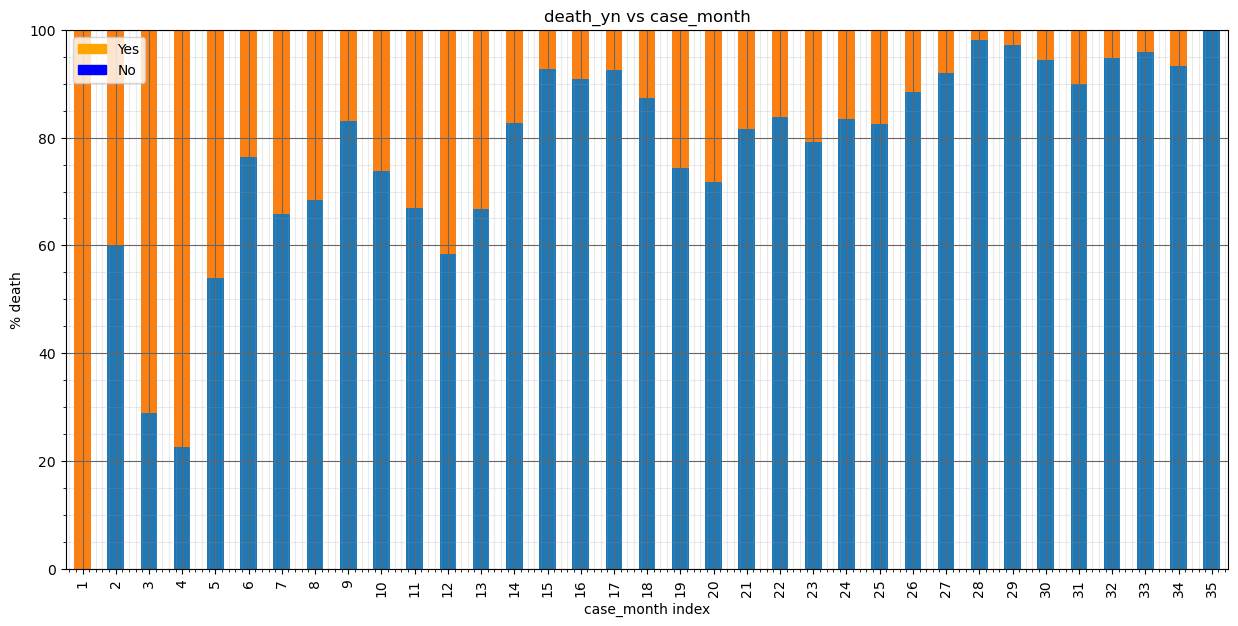

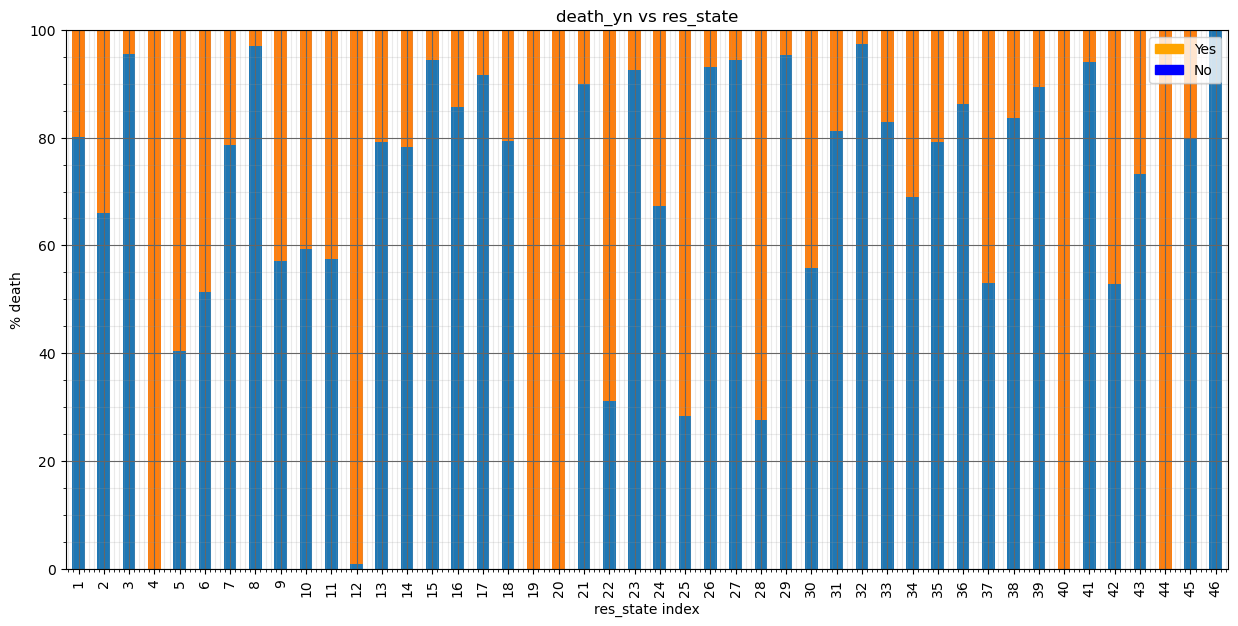

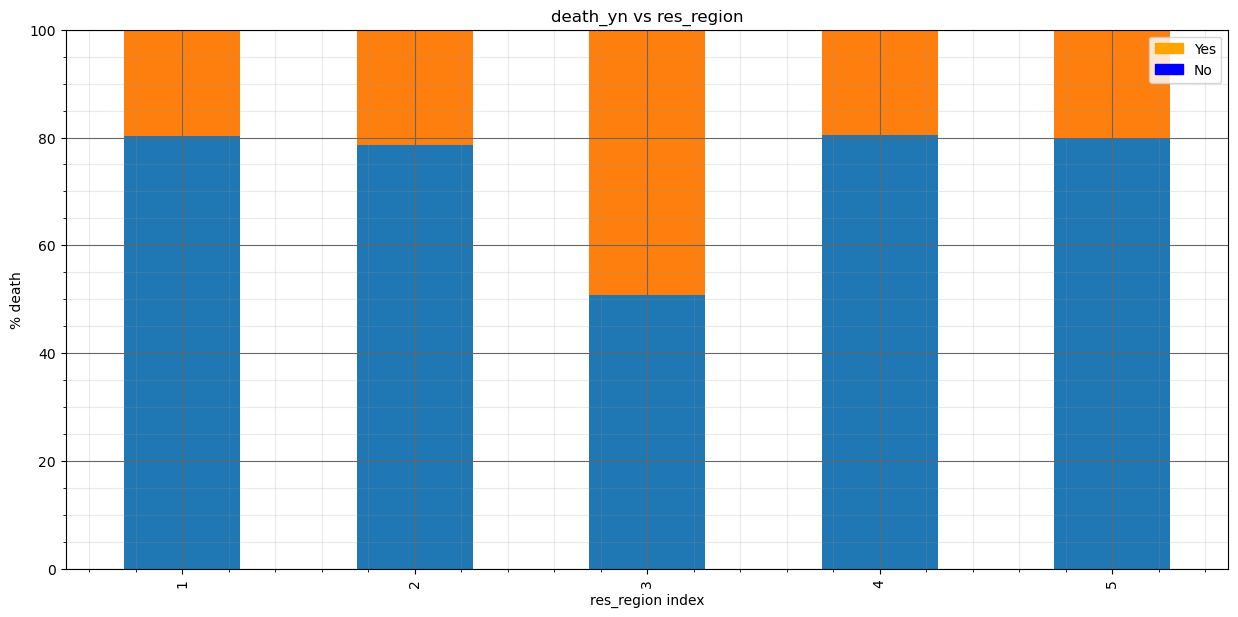

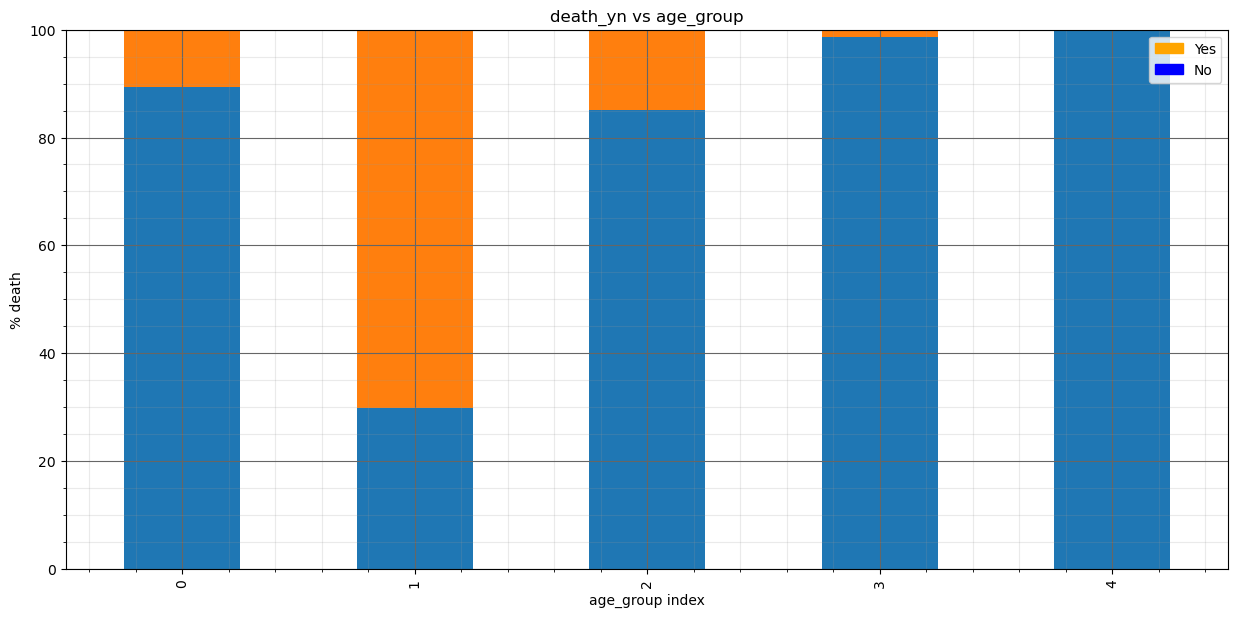

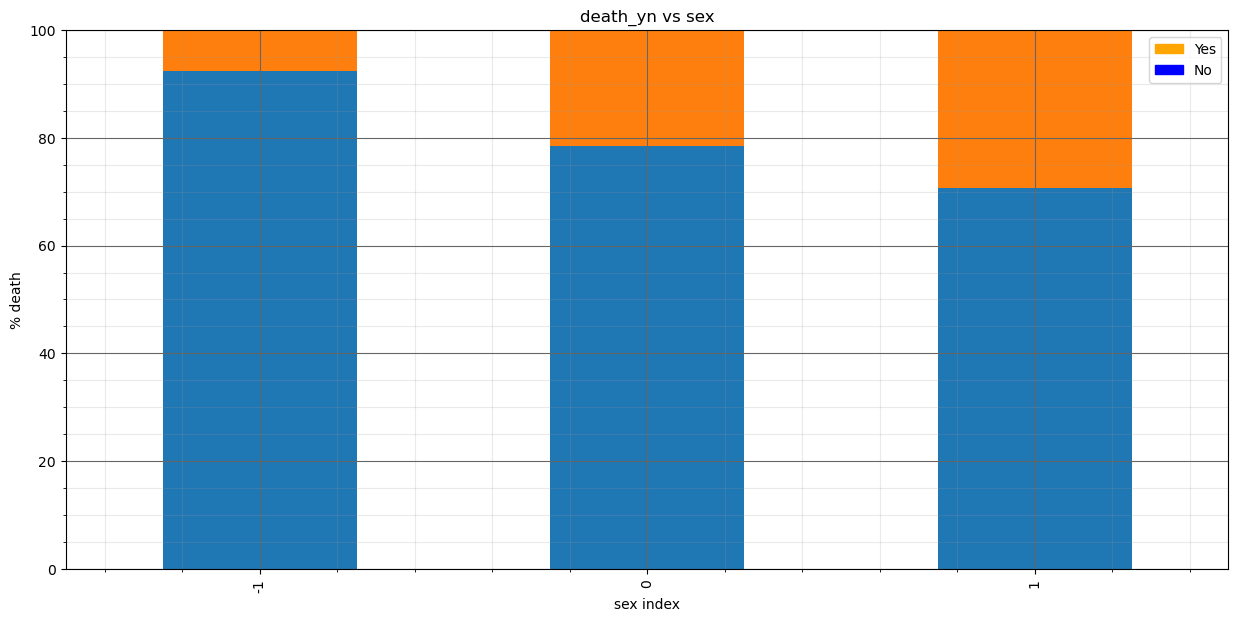

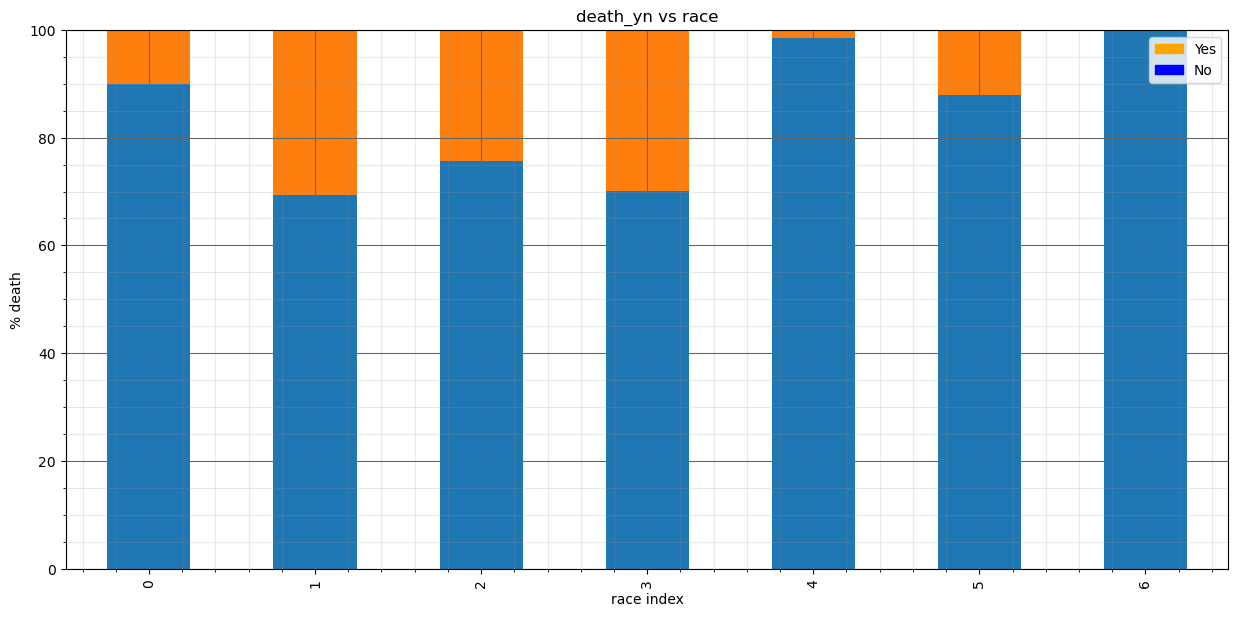

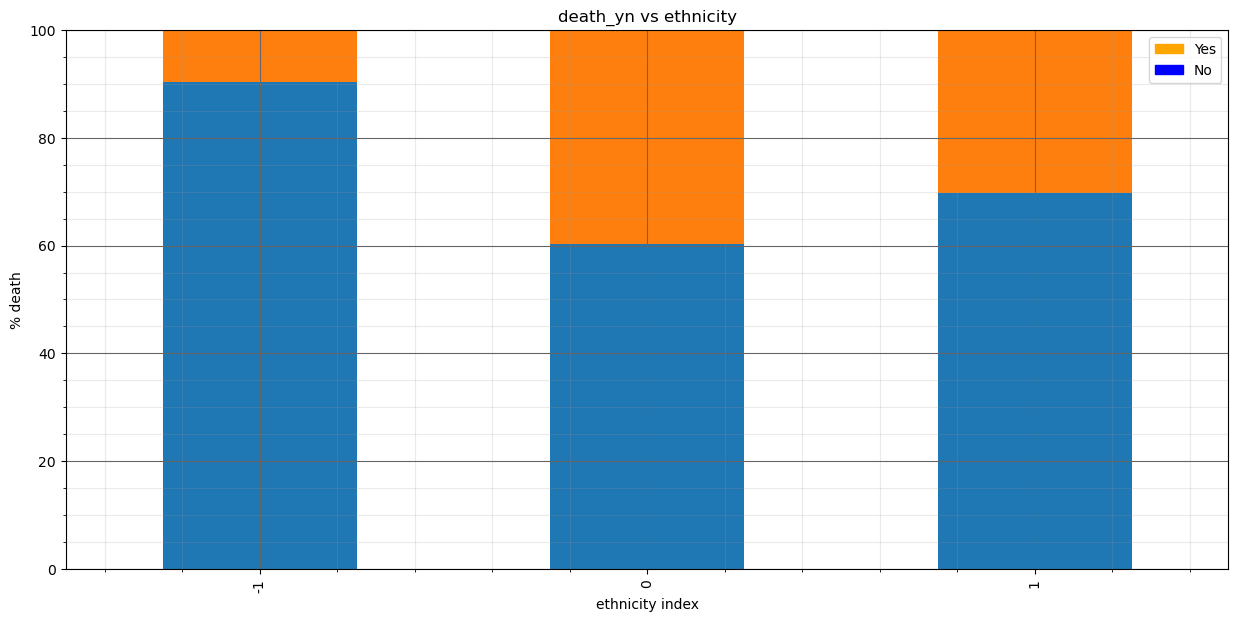

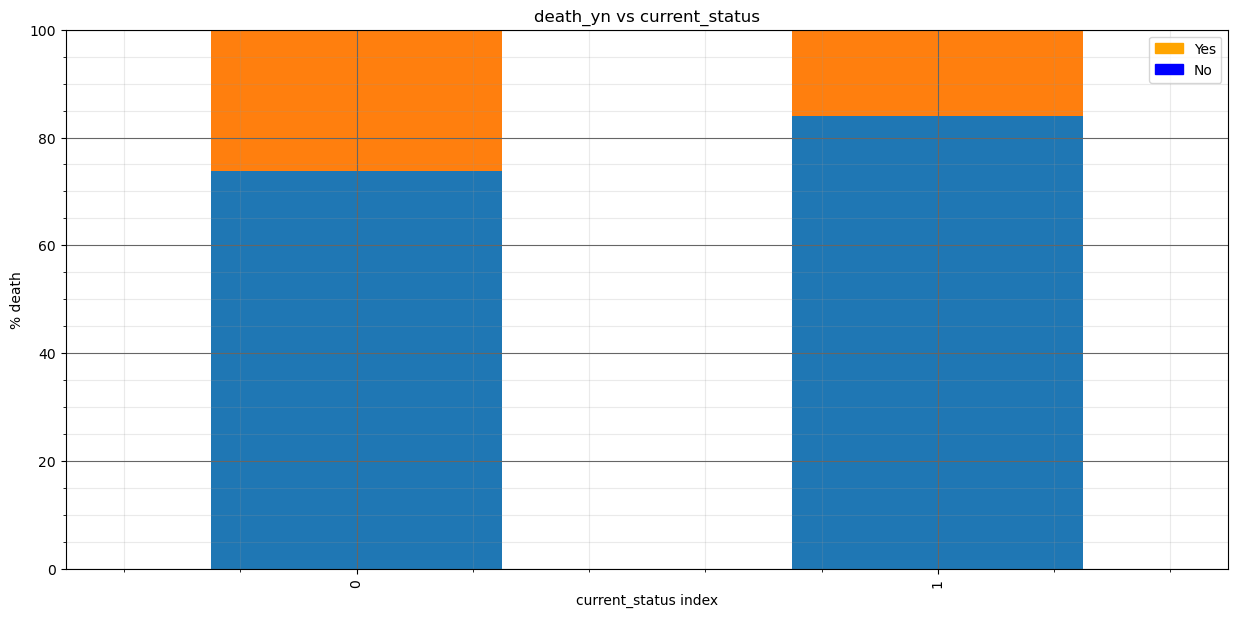

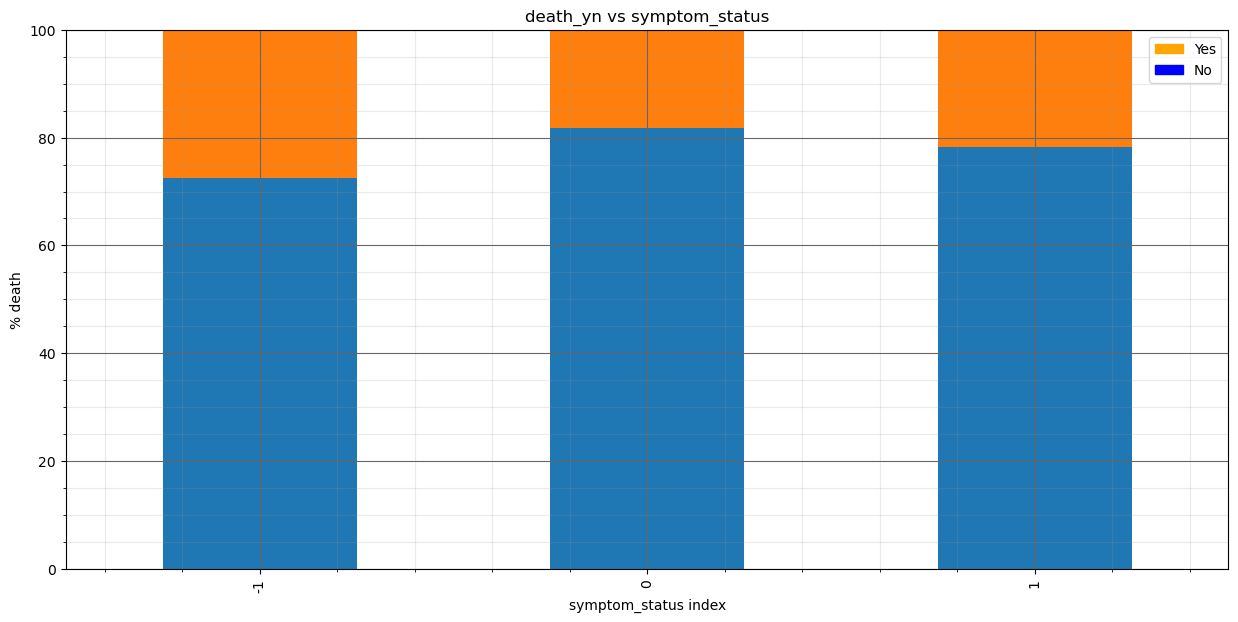

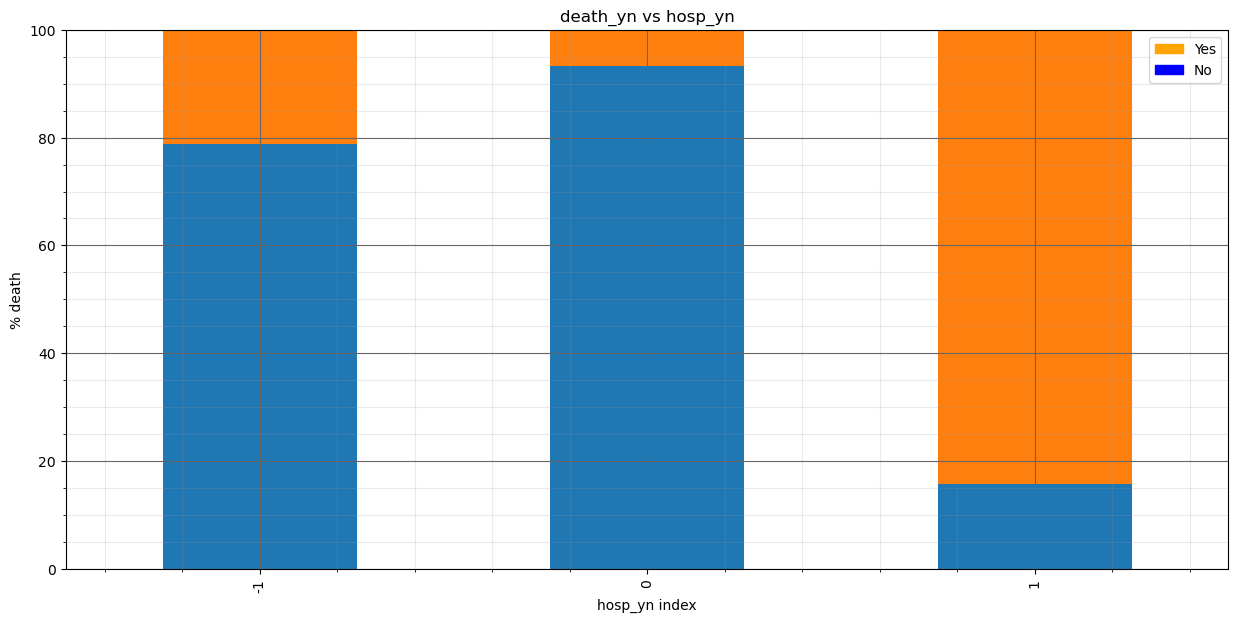

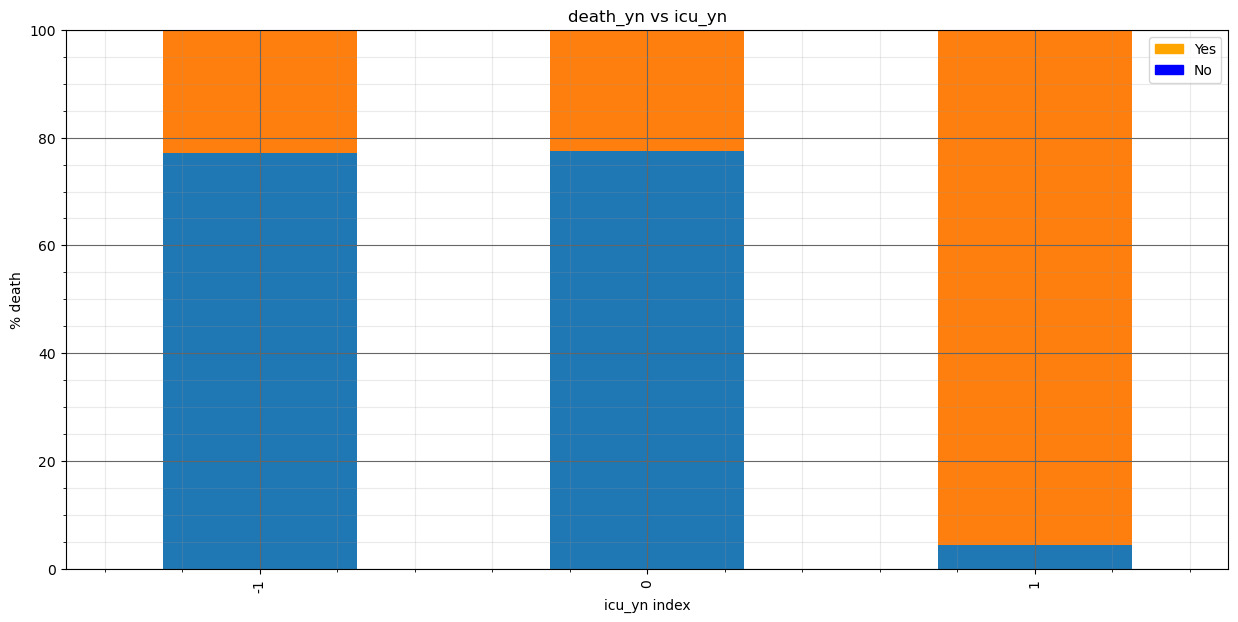

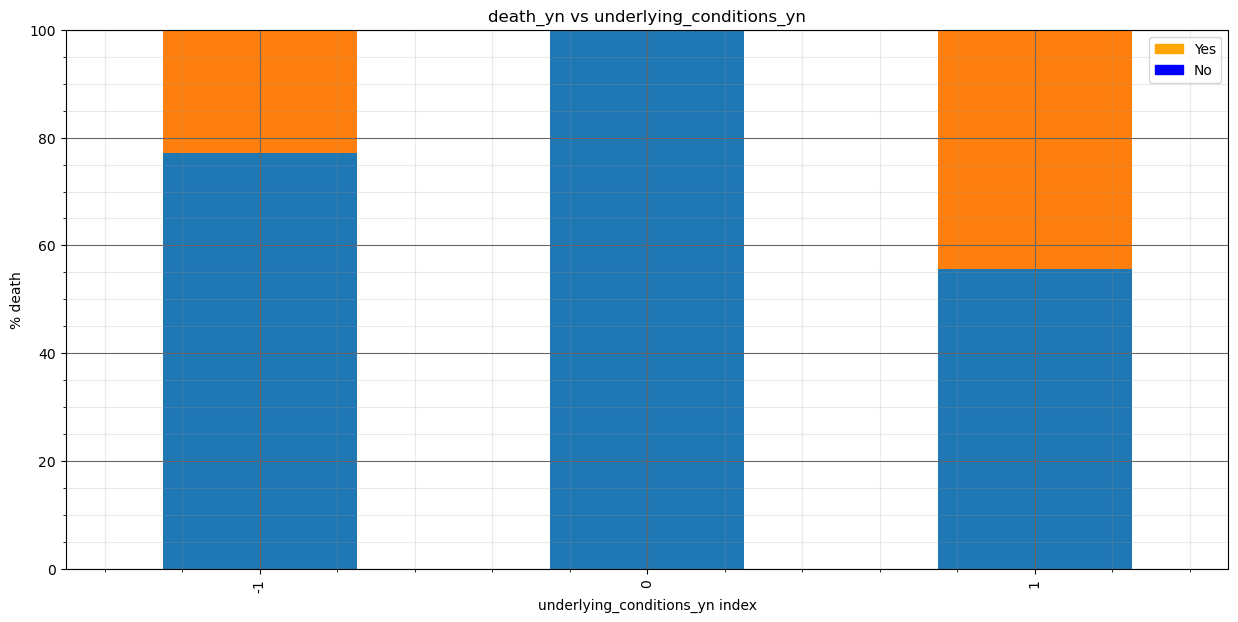

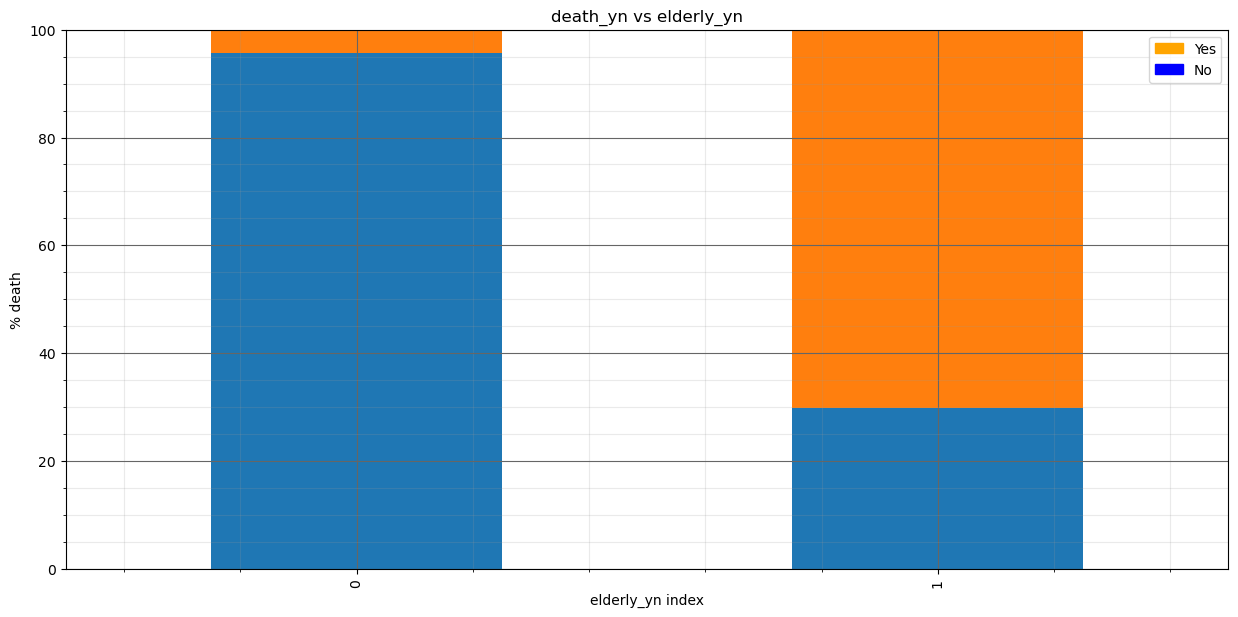

In [30]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category") 

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)

# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns_notarget:
    
    categorial_features_ravel = pd.unique(df_temp[categorical_feature].ravel())
    # add new column and set values to zero
    df_temp['percent'] = 0
   
    #print header
    print("\n", categorical_feature)
    print("Index \t Count")
    
    # for each covid caused category
    for i in categorial_features_ravel: 
        
        count = df_temp[df_temp[categorical_feature] == i].count()['death_yn']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'death_yn']].groupby([categorical_feature,'death_yn']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"death_yn vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Yes')
    blue_patch = mpatches.Patch(color='blue', label='No')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)

    # add labels
    my_plot.set_xlabel(f"{categorical_feature} index")
    my_plot.set_ylabel("% death")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
# df_temp = df_temp.drop("percent", 1)   
    
    

#### Reminder of scale meanings

| death_yn  | icu_yn    |elderly_yn|underlying_conditions_yn |hosp_yn  |meaning   |current_status           |
|-----------|-----------|----------|-------------------------|---------|----------|-------------------------|
| 0         | 0         |0         |0                        |0        |no        |Laboratory-confirmed case|
| 1         | 1         |1         |1                        |1        |yes       |Probable Case            |
|           | -1        |          |-1                       |-1       |missing   |                         |

| sex | meaning   | ethnicity | meaning           |symptom_status|meaning
|-----|-----------|-----------|-------------------|--------------|---------------|
| 0   |female     | 0         |Hispanic/Latino    |0             |Asymptomatic   |
| 1   |male       | 1         |Non-Hispanic/Latino|1             |Symptomatic    |
| -1  |missing    | -1        |missing            |-1            |unknown        |


|age_group | meaning       | race | meaning                                | res_region | meaning| 
|----------|---------------|------|----------------------------------------|------------|--------|
| 0        | missing       | 0    | missing                                | 1          | S      |
| 1        | 65+ years     | 1    | White                                  | 2          | N      |
| 2        | 50 to 64 years| 2    | Black                                  | 3          | W      |
| 3        | 18 to 49 years| 3    | Asian                                  | 4          | M      |
| 4        | 0 - 17 years  | 4    | Multiple/other                         | 5          | O      |
|          |               | 5    | American Indian/Alaska Native          |            |        |
|          |               | 6    | Native Hawaiian/Other Pacific Islander |            |        |

#### Interpretation of the results
##### death_yn vs case_month
- Observing the plots we can see that as the case_month index increases we see a reduction in death cases. This is expected.
- Caution needs to be observed here as index 28,19,46,40,42,37,43,45,44 have only a small number of entries. Please see table above. For example, the index 44,45 have only 17 and 5 entries individually.
- Due to this it is hard to say without more data if the duration for the cases occur has a significant effect on death rate.
- It is likely the integer outcome will capture this data sufficiently, will keep this feature for further analysis.

##### death_yn vs res_state
- Observing the plots we can see that the death rate for each res_state index varies.
- Caution needs to be observed here as index 0 with value missing. Please see table above. The index -1 has only 7 and 5 entries individually.
- We will look into details for feature res_region classifying states by region which is more valuable, this feature will not be kept for further analysis.

##### death_yn vs res_region
- Observing the plot above we can see that region with index 1 has higher death cases than other regions.
- The other indexes of regions have an evenly distribution of death cases.
- Caution needs to be observed here as index 5 have only a small number of entries. Please see table above. 
- Will keep this feature for future analysis.

##### death_yn vs age_group
- Observing the plots we can see that after index 0, as the age_group index increases we see a reduction in death cases. This is expected.
- We will look into details for feature elderly_yn classifying age groups by whether is 65+ years old which is more valuable.
- This feature will still be kept for further analysis.

##### death_yn vs elderly_yn
- Observing the plots we can see that icu_yn index 1 has much higher death rate than index 0. This is expected.
- Will keep this feature for future analysis.

##### death_yn vs sex
- Observing the plots we can see that as the death rate for index 1 and 0 are relatively close，with index 0 having a slightly higher death rate than index 1.
- Caution needs to be observed here as index -1 with 746 entries of missing. Please see table above. 
- The difference between the 2 outcomes with or without index -1 are not a big as expected and highlight that effect that all the other features can have on the death rate.
- This feature will not be kept for further analysis.

##### death_yn vs race
- Observing the plots we can see that the death rate for each race index varies.
- Caution needs to be observed here as index 5,6 have only a small number of entries. Please see table above. For example, the index 5,6 have only 99 and 2 entries individually.
- Due to this it is hard to say without more data if the race factor has a significant effect on death rate.
- This feature will not be kept for further analysis.

##### death_yn vs ethnicity
- Observing the plots we can see that as the death rate for index 1 and 0 are relatively close，with index 1 having a slightly higher death rate than index 0.
- Caution needs to be observed here as index -1 with value missing. Please see table above. The index 0 has 8627 entries which may has an effect on the result.
- Due to this it is hard to say without more data if the ethnicity factor has a significant effect on death rate.
- Hence the feature ethnicity will not be taken into further analysis.

##### death_yn vs current_status
- Observing the plots we can see that as the death rate for index 1 and 0 are relatively close，with index 0 having a slightly higher death rate than index 1.
- Caution needs to be observed here as the big difference between amount of index 0 and index 1 may has an effect on the result. Please see table above. The index 0 has 23689 entries while the index has 4236 entries.
- Due to this it is hard to say without more data if the current_status factor has a significant effect on death rate.
- Will still keep this feature for future analysis.

##### death_yn vs symptom_status
- Observing the plots we can see that as the death rate for index 1 and 0 are relatively close，with index 1 having a slightly higher death rate than index 0.
- Caution needs to be observed here as index -1 with value missing. Please see table above. The index -1 has 14807 entries which may has an effect on the result.
- However, given that this feature is very important and may affect the following analysis, will still keep it for future analysis.

##### death_yn vs hosp_yn
- Observing the plots we can see that hosp_yn index 1 has much higher death rate than index 0. This is expected.
- Caution needs to be observed here as index -1 with value missing. Please see table above. The index -1 has 9392 entries which may has an effect on the result.
- However, given that this feature is very important and may affect the following analysis, will still keep it for future analysis.

##### death_yn vs icu_yn
- Observing the plots we can see that icu_yn index 1 has much higher death rate than index 0. This is expected.
- Caution needs to be observed here as index -1 with value missing. Please see table above. The index -1 has 25562 entries which may has an effect on the result.
- However, given that this feature is very important and may affect the following analysis, will still keep it for future analysis.

##### death_yn vs underlying_conditions_yn
- Observing the plots we can see that icu_yn index 1 has much higher death rate than index 0. This is expected.
- Caution needs to be observed here as index -1 with value missing. Please see table above. The index -1 has 25465 entries which may has an effect on the result.
- However, given that this feature is very important and may affect the following analysis, will still keep it for future analysis.


**9 categorical features as 'case_month', 'res_region', 'age_group', 'elderly_yn', 'current_status', 'sex', 'symptop_status', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn' will be kept for now but it is expected that 'case_month', elderly_yn, 'symptom_status' and 'underlying_conditions_yn' will have the greater effect**

**Current status : Drop res_state, county_fips_code, race, ethnicity**
- We will label these as low_information_gain features

In [31]:
low_information_gain = ['res_state','county_fips_code','sex','race','ethnicity']

### 1.2.2 Summary & Drop Features

1. From Categorial vs Categorial plots (1.2.1) we identified the following to be dropped

In [32]:
low_information_gain

['res_state', 'county_fips_code', 'sex', 'race', 'ethnicity']

We will now drop these features
- Before dropping we will duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)

In [33]:
# before dropping make copy of original
df_rev1 = df.copy()
# drop low value features
df_rev1.drop(low_information_gain, axis=1, inplace=True)
print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['case_month', 'age_group', 'current_status', 'symptom_status',
       'hosp_yn', 'icu_yn', 'death_yn', 'underlying_conditions_yn',
       'res_region', 'elderly_yn'],
      dtype='object')

New shape: (39893, 10)


## 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included

#### Set up dummy features. 
This will split up each categorical feature into a number of dummy features. The data type changes to "uint8"

In [34]:
# set up dummies features
df_rev1 = pd.get_dummies(df_rev1)

# set the display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# display the data types of all columns
print(df_rev1.dtypes)

death_yn                       int64
case_month_1                    bool
case_month_2                    bool
case_month_3                    bool
case_month_4                    bool
case_month_5                    bool
case_month_6                    bool
case_month_7                    bool
case_month_8                    bool
case_month_9                    bool
case_month_10                   bool
case_month_11                   bool
case_month_12                   bool
case_month_13                   bool
case_month_14                   bool
case_month_15                   bool
case_month_16                   bool
case_month_17                   bool
case_month_18                   bool
case_month_19                   bool
case_month_20                   bool
case_month_21                   bool
case_month_22                   bool
case_month_23                   bool
case_month_24                   bool
case_month_25                   bool
case_month_26                   bool
c

In [35]:
# get boolean columns
bool_cols = df_rev1.select_dtypes(include='bool').columns

# convert boolean columns to uint8
df_rev1[bool_cols] = df_rev1[bool_cols].astype('uint8')

In [36]:
df_rev1.dtypes

death_yn                       int64
case_month_1                   uint8
case_month_2                   uint8
case_month_3                   uint8
case_month_4                   uint8
case_month_5                   uint8
case_month_6                   uint8
case_month_7                   uint8
case_month_8                   uint8
case_month_9                   uint8
case_month_10                  uint8
case_month_11                  uint8
case_month_12                  uint8
case_month_13                  uint8
case_month_14                  uint8
case_month_15                  uint8
case_month_16                  uint8
case_month_17                  uint8
case_month_18                  uint8
case_month_19                  uint8
case_month_20                  uint8
case_month_21                  uint8
case_month_22                  uint8
case_month_23                  uint8
case_month_24                  uint8
case_month_25                  uint8
case_month_26                  uint8
c

In [37]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['case_month_1',
 'case_month_2',
 'case_month_3',
 'case_month_4',
 'case_month_5',
 'case_month_6',
 'case_month_7',
 'case_month_8',
 'case_month_9',
 'case_month_10',
 'case_month_11',
 'case_month_12',
 'case_month_13',
 'case_month_14',
 'case_month_15',
 'case_month_16',
 'case_month_17',
 'case_month_18',
 'case_month_19',
 'case_month_20',
 'case_month_21',
 'case_month_22',
 'case_month_23',
 'case_month_24',
 'case_month_25',
 'case_month_26',
 'case_month_27',
 'case_month_28',
 'case_month_29',
 'case_month_30',
 'case_month_31',
 'case_month_32',
 'case_month_33',
 'case_month_34',
 'case_month_35',
 'age_group_0',
 'age_group_1',
 'age_group_2',
 'age_group_3',
 'age_group_4',
 'current_status_0',
 'current_status_1',
 'symptom_status_-1',
 'symptom_status_0',
 'symptom_status_1',
 'hosp_yn_-1',
 'hosp_yn_0',
 'hosp_yn_1',
 'icu_yn_-1',
 'icu_yn_0',
 'icu_yn_1',
 'underlying_conditions_yn_-1',
 'underlying_conditions_yn_0',
 'underlying_conditions_yn_1',
 'res_region_1',

#### Total features are:

In [38]:
features = categorical_columns
features

['case_month_1',
 'case_month_2',
 'case_month_3',
 'case_month_4',
 'case_month_5',
 'case_month_6',
 'case_month_7',
 'case_month_8',
 'case_month_9',
 'case_month_10',
 'case_month_11',
 'case_month_12',
 'case_month_13',
 'case_month_14',
 'case_month_15',
 'case_month_16',
 'case_month_17',
 'case_month_18',
 'case_month_19',
 'case_month_20',
 'case_month_21',
 'case_month_22',
 'case_month_23',
 'case_month_24',
 'case_month_25',
 'case_month_26',
 'case_month_27',
 'case_month_28',
 'case_month_29',
 'case_month_30',
 'case_month_31',
 'case_month_32',
 'case_month_33',
 'case_month_34',
 'case_month_35',
 'age_group_0',
 'age_group_1',
 'age_group_2',
 'age_group_3',
 'age_group_4',
 'current_status_0',
 'current_status_1',
 'symptom_status_-1',
 'symptom_status_0',
 'symptom_status_1',
 'hosp_yn_-1',
 'hosp_yn_0',
 'hosp_yn_1',
 'icu_yn_-1',
 'icu_yn_0',
 'icu_yn_1',
 'underlying_conditions_yn_-1',
 'underlying_conditions_yn_0',
 'underlying_conditions_yn_1',
 'res_region_1',

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [39]:
# y is the target
y = df_rev1["death_yn"]
# X is everything else
X = df_rev1.drop(["death_yn"],axis=1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  39893
training range (70%):	 rows 0 to 27925
test range (30%): 	 rows 27925 to 39893


In [40]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
        case_month_1  case_month_2  case_month_3  case_month_4  case_month_5   
35751             0             0             0             0             0  \
14416             0             0             0             0             0   
8994              0             0             0             0             0   
18816             0             0             0             0             0   
28819             0             0             0             0             0   

       case_month_6  case_month_7  case_month_8  case_month_9  case_month_10   
35751             0             0             0             0              0  \
14416             0             0             0             0              0   
8994              0             1             0             0              0   
18816             0             0             0             0              0   
28819             0             0             0             0              0   

       case_mon

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [41]:
X_train.head(5)

,case_month_1,case_month_2,case_month_3,case_month_4,case_month_5,case_month_6,case_month_7,case_month_8,case_month_9,case_month_10,case_month_11,case_month_12,case_month_13,case_month_14,case_month_15,case_month_16,case_month_17,case_month_18,case_month_19,case_month_20,case_month_21,case_month_22,case_month_23,case_month_24,case_month_25,case_month_26,case_month_27,case_month_28,case_month_29,case_month_30,case_month_31,case_month_32,case_month_33,case_month_34,case_month_35,age_group_0,age_group_1,age_group_2,age_group_3,age_group_4,current_status_0,current_status_1,symptom_status_-1,symptom_status_0,symptom_status_1,hosp_yn_-1,hosp_yn_0,hosp_yn_1,icu_yn_-1,icu_yn_0,icu_yn_1,underlying_conditions_yn_-1,underlying_conditions_yn_0,underlying_conditions_yn_1,res_region_1,res_region_2,res_region_3,res_region_4,res_region_5,elderly_yn_0,elderly_yn_1
35751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
14416,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
8994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1
18816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
28819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0


We will now reset the index of all training and test dataframes

In [42]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,case_month_1,case_month_2,case_month_3,case_month_4,case_month_5,case_month_6,case_month_7,case_month_8,case_month_9,case_month_10,case_month_11,case_month_12,case_month_13,case_month_14,case_month_15,case_month_16,case_month_17,case_month_18,case_month_19,case_month_20,case_month_21,case_month_22,case_month_23,case_month_24,case_month_25,case_month_26,case_month_27,case_month_28,case_month_29,case_month_30,case_month_31,case_month_32,case_month_33,case_month_34,case_month_35,age_group_0,age_group_1,age_group_2,age_group_3,age_group_4,current_status_0,current_status_1,symptom_status_-1,symptom_status_0,symptom_status_1,hosp_yn_-1,hosp_yn_0,hosp_yn_1,icu_yn_-1,icu_yn_0,icu_yn_1,underlying_conditions_yn_-1,underlying_conditions_yn_0,underlying_conditions_yn_1,res_region_1,res_region_2,res_region_3,res_region_4,res_region_5,elderly_yn_0,elderly_yn_1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0


The datasets are now ready for modeling

## (2) Linear Regression Model
#### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above

In [43]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### 2.2 Print out the coefficients learned by the model

In [44]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['case_month_1', 'case_month_2', 'case_month_3', 'case_month_4',
       'case_month_5', 'case_month_6', 'case_month_7', 'case_month_8',
       'case_month_9', 'case_month_10', 'case_month_11', 'case_month_12',
       'case_month_13', 'case_month_14', 'case_month_15', 'case_month_16',
       'case_month_17', 'case_month_18', 'case_month_19', 'case_month_20',
       'case_month_21', 'case_month_22', 'case_month_23', 'case_month_24',
       'case_month_25', 'case_month_26', 'case_month_27', 'case_month_28',
       'case_month_29', 'case_month_30', 'case_month_31', 'case_month_32',
       'case_month_33', 'case_month_34', 'case_month_35', 'age_group_0',
       'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'current_status_0', 'current_status_1', 'symptom_status_-1',
       'symptom_status_0', 'symptom_status_1', 'hosp_yn_-1', 'hosp_yn_0',
       'hosp_yn_1', 'icu_yn_-1', 'icu_yn_0', 'icu_yn_1',
       'underlying_conditions_yn_-1', 'underlying_con

#### 2.3 Predicted target features and evaluate the prediction metric

#### 2.3.1 Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

In [45]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_yn  Predicted
0         0        0.0
1         0        0.0
2         0        0.0
3         0        0.0
4         0        0.0
5         0        0.0
6         0        0.0
7         1        1.0
8         0        0.0
9         1        1.0


#### 2.3.2 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [46]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9256222023276633
Confusion matrix: 
 [[19839  1179]
 [  898  6009]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.94      0.95     21018
           1       0.84      0.87      0.85      6907

    accuracy                           0.93     27925
   macro avg       0.90      0.91      0.90     27925
weighted avg       0.93      0.93      0.93     27925



##### Interpretation of results
- Accuracy
    - This is simply stating how often the model is correct. We have an accuracy of 92%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
- Precision - How good the model is at predicting the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - Precision Positive is 0.84
    - Precision Negative is 0.96
- Recall
    - What % of the positive values did we predict
    - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 0.87
    - Recall Negative is 0.94
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.85
    - F1 Score Negative is 0.95

Summary
- The model has performed well, with a high accuracy and good precision and recall for both negative and positive classes.
- This makes sense as the model has more negative data to learn from - it is the majority class. 
- This is ideal because it is consistent with more accurate labeling of reasons caused the death.
- The precision and recall for positive class are slightly lower than those for negative class, which suggests that the model may be better at predicting instances of negative class than instances of positive class.

#### 2.4 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

#### 2.4.1 Compare these results with the evaluation results obtained on the training (70%) dataset.

Printing Actual death_yn vs predicted based on test data

In [47]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_yn  Predicted
0          0        0.0
1          0        0.0
2          0        0.0
3          0        0.0
4          0        0.0
5          0        0.0
6          0        0.0
7          1        1.0
8          1        1.0
9          1        1.0
10         1        1.0
11         1        1.0
12         0        0.0
13         0        0.0
14         0        0.0
15         0        0.0
16         1        1.0
17         1        1.0
18         1        1.0
19         0        0.0
20         0        0.0
21         0        0.0
22         0        0.0
23         0        0.0
24         0        0.0
25         1        1.0
26         0        0.0
27         1        1.0
28         0        0.0
29         1        1.0
30         1        1.0
31         0        0.0
32         0        1.0
33         1        1.0
34         0        0.0
35         0        0.0
36         0        0.0
37         0        0.0
38         0    

##### Evaluation metrics based on test data

In [48]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9240474598930482
Confusion matrix: 
 [[8458  514]
 [ 395 2601]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.96      0.94      0.95      8972
           1       0.83      0.87      0.85      2996

    accuracy                           0.92     11968
   macro avg       0.90      0.91      0.90     11968
weighted avg       0.93      0.92      0.92     11968


==================== Train Data ======================
Accuracy:  0.9256222023276633
Confusion matrix: 
 [[19839  1179]
 [  898  6009]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.96      0.94      0.95     21018
           1       0.84      0.87      0.85      6907

    accuracy                           0.93     27925
   macro avg       0.90      0.91      0.90     27925
weighted avg       0.93      0.93      0.93     27925

**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test data is marginally lower 92.56% vs 92.40%. 
- Precision
    - The precision score for predicting the positive case has marginally lower from 84% to 83%.
    - The precision score for predicting the negative case is the same as training results with 96%.
- Recall
    - The recall score for predicting the positive case is the same as training results with 87%.
    - The recall score for predicting the negative case is the same as training results with 94%.
- F1
    - The f1 score for predicting the positive case is the same as training results with 85%.
    - The f1 score for predicting the negative case is the same as training results with 95%.

**Summary**
- The model performs similarly on both training and testing data, suggesting that it is generalizing well and is not overfitting.
- The model's performance is better for negative cases than positive cases.
- More comparisons need to be made and this is where cross validation steps in.

#### 2.4.2 Cross validation
- We will now perform cross validation on the linear regression model. 
- Here we perform the same evaluation as above but multiple times
- Each time the data is shuffled so we get a slightly different view of the data for training and testing
- This works well for evaluating on a limited set of data
- We will store the results in a dictionary for later use

First we need to create a function to perform this cross validation. Sklearn does not provide one for linear regression. However it does for logistic and random forests models
- Cross validation Function can be seen below

In [49]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [50]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarised below

In [51]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.925919
precision,0.840229
recall,0.866202
f1,0.852976


- These results are marginally higher than previous results but this is expected. We have taken the mean of 10 sets of results. 
- It indicates that the model is performing consistently well across different splits of the data. 
- And this suggests that the model is less likely to be overfitting to the training data, and that it is more robust and reliable.

## (3) Logistic Regression  

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above

In [52]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

#### 3.2 Print out the coefficients learned by the model

In [53]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['case_month_1', 'case_month_2', 'case_month_3', 'case_month_4',
       'case_month_5', 'case_month_6', 'case_month_7', 'case_month_8',
       'case_month_9', 'case_month_10', 'case_month_11', 'case_month_12',
       'case_month_13', 'case_month_14', 'case_month_15', 'case_month_16',
       'case_month_17', 'case_month_18', 'case_month_19', 'case_month_20',
       'case_month_21', 'case_month_22', 'case_month_23', 'case_month_24',
       'case_month_25', 'case_month_26', 'case_month_27', 'case_month_28',
       'case_month_29', 'case_month_30', 'case_month_31', 'case_month_32',
       'case_month_33', 'case_month_34', 'case_month_35', 'age_group_0',
       'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'current_status_0', 'current_status_1', 'symptom_status_-1',
       'symptom_status_0', 'symptom_status_1', 'hosp_yn_-1', 'hosp_yn_0',
       'hosp_yn_1', 'icu_yn_-1', 'icu_yn_0', 'icu_yn_1',
       'underlying_conditions_yn_-1', 'underlying_con

#### 3.3 Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 10 training examples based on training data

In [54]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   death_yn  Predicted
0         0          0
1         0          0
2         0          0
3         0          0
4         0          0
5         0          0
6         0          0
7         1          1
8         0          0
9         1          1


#### 3.4 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

#### 3.4.1 Evaluate the model using the training (70% examples) set

In [55]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9287735004476275
Confusion matrix: 
 [[19996  1022]
 [  967  5940]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.95      0.95     21018
           1       0.85      0.86      0.86      6907

    accuracy                           0.93     27925
   macro avg       0.90      0.91      0.90     27925
weighted avg       0.93      0.93      0.93     27925



Interpretation of results
- Accuracy
    - We have an accuracy of 92%
- Precision - How good model is a prediction the positive class
    - Precision Positive is 0.85
    - Precision Negative is 0.95
- Recall - What % of the positive values did we predict
    - Recall Positive is 0.86
    - Recall Negative is 0.95
- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.86
    - F1 Score Negative is 0.95


Summary
- These values seem reasonable
- Accuracy is in line with the linear regression model
- Overall the predictive power of the logic model is also a little better.

#### 3.4.2 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual death_yn vs predicted based on test data

In [56]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death_yn  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          0          0
7          1          1
8          1          1
9          1          1
10         1          1
11         1          1
12         0          0
13         0          0
14         0          0
15         0          0
16         1          1
17         1          1
18         1          1
19         0          0


In [57]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9277239304812834
Confusion matrix: 
 [[8538  434]
 [ 431 2565]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.95      0.95      8972
           1       0.86      0.86      0.86      2996

    accuracy                           0.93     11968
   macro avg       0.90      0.90      0.90     11968
weighted avg       0.93      0.93      0.93     11968

==================== Train Data =======================
Accuracy:  0.9287735004476275
Confusion matrix: 
 [[19996  1022]
 [  967  5940]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.95      0.95     21018
           1       0.85      0.86      0.86      6907

    accuracy                           0.93     27925
   macro avg       0.90      0.91      0.90     27925
weighted avg       0.93      0.93      0.93     27925



Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data is lower 92.87% vs 92.77%. 
- Precision
    - The precision score for predicting the positive case has increased from 85% to 86%.
    - The precision score for predicting the negative case has kept the same as 95%.
- Recall
    - The recall score for predicting the positive case has kept the same as 86%.
    - The recall score for predicting the negative case has kept the same as 95%.
- F1
    - The f1 score for predicting the positive case has kept the same as 86%.
    - The f1 score for predicting the negative case has kept the same as 95%.

Summary
- These values see reasonable
- The accuracy level have dropped which is normal as we are testing the model on data it has not see before
- This is a good sign that the model is generalizing
- More comparisons need to be made and this is where cross validation steps in

#### 3.4.3 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [58]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [59]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.928008
precision,0.854614
recall,0.855802
f1,0.855133


These results are in line with the previous results. We have taken the mean of 10 sets of results. 

## (4) Random Forest Model

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

In [60]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

### 4.1.1 Understanding the Random Forest model
We will now try to understand how this random forest model works
- We will first start by trying to understand a decision tree 
- A random forest is made up of an ensemble/collection of decision trees
- Decision tree
    - A decision tree is a set of if-then-else rules based on splitting the data based on specific features
    - The decision on which feature to split on is based on the information gain (Gini index). 
    - The tree will always split on the feature that gives the highest information gain
    - The feature with the highest information gain will sit at the root of each decision tree
    - Each decision tree will be a single prediction
- Random Forest 
    - The random forest is made up of a number of decision trees
    - The output of the random forest is base on the majority output of all decision trees combined
    - This gives reliable results but can be hard to interpret
    - The random forest will keep track of the importance of features in terms of information gain, which we will see
    
We will now look at an example of a single decision tree to get a better understanding

####  4.1.2  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer

In [61]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


####  4.1.3  Display Decision tree
We will create graph of each tree and store as an image

In [62]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.806711 to fit


We can see below the decision tree with max_depth=4
- We can see the root is elderly_yn at value 0.5 - This splits the data best i.e. has the highest information gain
- For each split the the model selects the next best feature
- This continues until it reaches a leaf node where the data cannot be split anymore
- The output of this is the prediction
- We can see all these entries need additional branches to be resolved

<img src="DecisionTree4.png">

Viewing a decision tree with maxdepth=10 shows how complicated this model becomes 

<img src="DecisionTree10.png">

#### 4.1.4 Interpretation of the random forest model
As mentioned above the random forest will keep track of the importance of features
- We can see from the dataframe below the results of this feature importance ranking
- The more important features are the features that the random forest has identified as having higher information gain
- This list is the combined result of the 100 decision trees that make up the random forest model
- This feature ranking will help us in our optimisation process going forward
    - What are the best features to keep?
    - What features can be safely dropped without loosing information?

In [63]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
47,hosp_yn_1,1.504870e-01
60,elderly_yn_1,1.431736e-01
59,elderly_yn_0,1.427796e-01
36,age_group_1,1.318021e-01
46,hosp_yn_0,7.208489e-02
38,age_group_3,4.746003e-02
56,res_region_3,2.682976e-02
3,case_month_4,2.578572e-02
50,icu_yn_1,1.908249e-02
45,hosp_yn_-1,1.727824e-02


 - The list shows the feature importance values for different features in a model, sorted in descending order of importance. 
 - Each row represents a specific feature and its corresponding importance value.
 - Based on the list, we can see that the top four most important features are:
    hosp_yn_1，
    elderly_yn_1，
    elderly_yn_0，
    age_group_1
 - These features have the highest importance values in the model and thus have the greatest impact on the model's predictions.
 - Additionally, we can see that some features have very low importance values, such as underlying_conditions_yn_0 with an importance value of 2.544590e-07. This indicates that this feature has very little impact on the model's predictions.
 - Overall, the list provides insight into which features are most important in the model and can help guide feature selection or further analysis.

### 4.3 Printing 10 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 10 training examples. 

### 4.3.1 Printing 10 predicted target features

In [64]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,1,1


### 4.3.2 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [65]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9507609668755596
Confusion matrix: 
 [[20271   747]
 [  628  6279]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.96      0.97     21018
           1       0.89      0.91      0.90      6907

    accuracy                           0.95     27925
   macro avg       0.93      0.94      0.93     27925
weighted avg       0.95      0.95      0.95     27925



summary:

- The model performs well on the training dataset, with high accuracy, precision, recall, and F1-score.
- Prediction for negative cases performs better than positive cases.
- It is important to note that the evaluation on the training dataset may not be representative of the model's performance on new, unseen data
- It is necessary to also evaluate the model on a separate test dataset to ensure its generalization ability.

### 4.4 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

### 4.4.1 Printing Actual death_yn vs predicted based on test data

In [66]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,1,0
9,1,1


### 4.4.2 Evaluation metrics based on test data

In [67]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9297292780748663
Confusion matrix: 
 [[8514  458]
 [ 383 2613]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.95      0.95      8972
           1       0.85      0.87      0.86      2996

    accuracy                           0.93     11968
   macro avg       0.90      0.91      0.91     11968
weighted avg       0.93      0.93      0.93     11968

==================== Train Data =======================
Accuracy:  0.9507609668755596
Confusion matrix: 
 [[20271   747]
 [  628  6279]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.96      0.97     21018
           1       0.89      0.91      0.90      6907

    accuracy                           0.95     27925
   macro avg       0.93      0.94      0.93     27925
weighted avg       0.95      0.95      0.95     27925



Interpretation of test results and comparison with training results 
- Overall, the model performs well on both the training and test datasets, with high accuracy, precision, recall, and F1-score. 
- On the test dataset, the model has an accuracy of 0.9297, which is slightly lower than the accuracy on the training dataset. 
- The confusion matrix and classification report show that the model has high precision, recall, and F1-score for both positive and negative classes on the test dataset, but slightly lower than those on the training dataset. 
- This suggests that the model generalizes well to new, unseen data, but may not perform as well as it did on the training dataset.
- The scores seem reasonable and are in line with the other models test results

### 4.4.3 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [68]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [69]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.931116
precision,0.857534
recall,0.866707
f1,0.862038


The results above are inline with expectation
- The accuracy is slightly higher than other models with 93%
- The precision, recall and f1 are also a bit higher and in line with the other models

#### 4.4.3.1 Out of bag accuracy
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.
- It is used as an additional measure and should be line with the cross validation results
- This is generally expected to be the lowest

In [70]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9271620411817368

This value 0.9271 is in line with the Cross validation result with accuracy 0.9311 above.

## (5) Improving Predictive Models

### 5.1.1 Which model of the ones trained above performs better at predicting the target feature? 
- All models perform almost identical on the test dataset +/- 0.5%
- Summary of the results so far can be seen below (based on predicting if death or not (death_yn yes=1))
- Note these results are for a subset of the original features i.e. In part 1 we dropped some of the low correlation features
    - In part 5.3 we will review the impact to the decisions taken in part 1

In [71]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.925919,0.928008,0.931116
precision,0.840229,0.854614,0.857534
recall,0.866202,0.855802,0.866707
f1,0.852976,0.855133,0.862038


### 5.1.2 Is the model more accurate than a simple model that always predicts the majority class
- We will compare our results above to a simple model which predicts for the majority class
- First we will get the breakdown of the test dataset and see which is the majority class

In [72]:
yes_count = y_test[y_test == 1].count()
no_count = y_test[y_test == 0].count()
total = yes_count + no_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number for death cases:\t {yes_count}\t{round(yes_count/len(y_test)*100,2)}%')
print(f'Total number for not death cases:\t {no_count}\t{round(no_count/len(y_test)*100,2)}%')

From original dataset: 		Count 11968
Total number for death cases:	 2996	25.03%
Total number for not death cases:	 8972	74.97%


- We can see the majority class is 0 or death_yn = no 
- We will now generate scores for predicting the majority class

In [73]:
# generate array of 11968 zeros (length of test dataset)
majority = np.zeros(11968)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.7496657754010695
Confusion matrix: 
 [[8972    0]
 [2996    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.75      1.00      0.86      8972
           1       0.00      0.00      0.00      2996

    accuracy                           0.75     11968
   macro avg       0.37      0.50      0.43     11968
weighted avg       0.56      0.75      0.64     11968



- For predicting yes outcome the simple model fails completely as expected
- For predicting the no outcome the simple model fares much better but still worse than all the other models outlined above
    - The precision is the same as the accuracy in this case - i.e. how good is it at predicting 0
    - The recall is 100% as all of the actual 0 values were predicted 0
    - The f1 is between the precision and recall as it is a weighted average of the two

### 5.1.3 Compare Model performance using different feature subsets 
#### 5.1.3.1 All features
- We will now repeat the tests using all features 
- First we set up the dataframe using the original features

In [74]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)
# set X,y
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],axis=1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  1446


With the dataframe now setup we will generate new set of results based on all the features
- This operation is simplified as we have set up functions in part 2,3,4 to allow cross validated scores to be returned in dataframes 

In [75]:
# calculate Linear regression again using all features
linRegDF = cross_val_LinReg_DF(X,y)

In [76]:
# calculate logistic regression again using all features
logRegDF = cross_val_LogReg_DF(X,y)

In [77]:
# calculate random forest results again using all features
RandomForestDF = cross_val_RandomForest_DF(X,y)

In [78]:
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.947811,0.955005,0.954829
precision,0.903496,0.912756,0.907183
recall,0.884095,0.905484,0.911440
f1,0.893686,0.909014,0.909214


#### 5.1.3.2 Comparison of feature set so far

In [79]:
print("\nScores using all features: 16 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 9 features (7 features dropped - from part 1)")
print("===================================================================")
print(ResultsDF)


Scores using all features: 16 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.947811             0.955005        0.954829
precision           0.903496             0.912756        0.907183
recall              0.884095             0.905484        0.911440
f1                  0.893686             0.909014        0.909214

Scores using subset of features: 9 features (7 features dropped - from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.925919             0.928008        0.931116
precision           0.840229             0.854614        0.857534
recall              0.866202             0.855802        0.866707
f1                  0.852976             0.855133        0.862038


- Comparing the two tables, we can see that the performance of all three models - Linear Regression, Logistic Regression, and Random Forests - has decreased when using a subset of features (9 features) compared to using all features (16 features).
- For Linear Regression, the accuracy dropped from 0.9478 to 0.9259, precision decreased from 0.9035 to 0.8402, recall decreased from 0.8841 to 0.8662, and F1 decreased from 0.8937 to 0.8530 when using only 9 features.
- Finally, Random Forests also showed a decrease in performance when using a subset of features, with accuracy dropping from 0.9548 to 0.9311, precision decreasing from 0.9072 to 0.8575, recall decreasing from 0.9114 to 0.8667, and F1 decreasing from 0.9092 to 0.8620.
- Therefore, we can conclude that using all features (16 features) provides better performance for all three models compared to using a subset of features (9 features). However, it is also important to consider the trade-offs between performance and computational complexity when using a larger number of features.

### 5.2 Comparison of feature set so far and improve the best model

#### 5.2.1 Further optimisations
- There are two possible options for optimizing the linear and logistic regression models
    - Deriving new features - Two of the derived features proposed in homework 1 performed well and so additional features will not be proposed.
    - Further reviewing the existing features to find the best combination - This has already been attempted 
    - In our case, random forest model performs better than other two models by using subset of features with higher overall performance metrics.
- We will therefore focus in the random forest model to see what optimization is possible. We will look at the following:
    1. Find best performing Max_Depth of decision tree while keeping accuracy high - reduce potential for overfitting and speed up model 
    2. Find lowest number estimators while keeping accuracy high- reduce unnecessary estimators as will slow down the model
    3. Find best preforming list of features ranked by feature importance - As we know there are many feature that add little the the model. Removing them will help generalise the model
        - Results here can be applied to all models 

In [80]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],axis=1)

In [84]:
# initialised empty daraframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(1,11):
    df1 = cross_val_RandomForest_DF(X,y,i)
    df1.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

In [85]:
# same calculation but use no max depth this time
no_max_depth = cross_val_RandomForest_DF(X,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
accuracy,0.751761,0.752413,0.772843,0.814179,0.858297,0.890232,0.908430,0.924574,0.932119,0.935152,0.954829
precision,0.000000,0.300000,0.994862,0.988689,0.967624,0.949738,0.944049,0.934724,0.913811,0.914145,0.907183
recall,0.000000,0.002626,0.085435,0.255288,0.444828,0.589224,0.671015,0.748564,0.802590,0.815715,0.911440
f1,0.000000,0.005137,0.154425,0.398189,0.606019,0.726563,0.784052,0.831023,0.854312,0.861925,0.909214


- As the depth of the tree increases, the accuracy, recall, and F1 score generally improve. This indicates that allowing the model to grow deeper results in better performance on the training data. However, the improvement rate seems to slow down as the depth increases.
- Precision appears to be less sensitive to the tree depth, and in some cases, it decreases with increased depth. This could indicate that the model might be overfitting to the training data as it grows deeper, leading to lower precision.
- We can see from above that the sweet spot appears to be with a max depth of 6. This will vary between datasets but it does let us know that there is little to be gained by having max_depth=None. Max_depth=None will significantly increase the model size. 
- At the depth of 6, the model achieves relatively high accuracy, precision, recall, and F1 scores compared to shallower trees, without becoming too complex. While the performance continues to improve at greater depths, the risk of overfitting also increases.

#### 5.2.2 Optimise Number of estimators
**Note: This calculation may take some time**

In [86]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],axis=1)

# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.925075,0.926378,0.942897,0.949716,0.952398,0.953952,0.955080,0.954829,0.955305
precision,0.846448,0.913070,0.908039,0.906084,0.905330,0.905798,0.907184,0.907183,0.907377
recall,0.852977,0.777444,0.856811,0.889729,0.902755,0.909118,0.912550,0.911440,0.913358
f1,0.849667,0.839716,0.881623,0.897786,0.903985,0.907404,0.909776,0.909214,0.910257


Increasing the number of estimators generally improves the performance of the model in terms of accuracy, precision, recall, and F1 score. However, there may be diminishing returns as the number of estimators increase beyond a certain point, as evidenced by the relatively small increase in performance between 64 and 200 estimators. For the sake of keeping the model size manageable we will keep the number of estimators at the default of 64.

#### 5.2.3 Optimise Number of features
- First calculate feature order of importance using all features

In [87]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

# Train RF with 64 trees
rfc = RandomForestClassifier(n_estimators=64, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature', inplace=True)
importance

,importance
feature,
elderly_yn_0,1.315108e-01
hosp_yn_1,9.963839e-02
age_group_1,9.233453e-02
elderly_yn_1,6.814040e-02
age_group_3,5.560819e-02
hosp_yn_0,4.746646e-02
res_state_4,2.181642e-02
case_month_4,1.820406e-02
ethnicity_-1,1.525777e-02


- Next calculate the optimum number of features
- There are many features in total (more due to dummy features), it can indeed generate many new features, making feature selection more complex. 
- In this case, we will aggregate the feature importances for each original categorical feature. 
- To do this, can sum up the importances of all dummy variables corresponding to each original categorical feature.

In [88]:
# Assuming 'importance' is the DataFrame containing feature importances
original_importance = importance.reset_index()
original_importance['original_feature'] = original_importance['feature'].apply(lambda x: x.split('_')[0])
aggregated_importance = original_importance.groupby('original_feature').sum().sort_values('importance', ascending=False)


import re

def extract_original_feature(feature_name):
    # Define a list of specific prefixes
    specific_prefixes = ['res_state', 'res_region']

    # Remove the "_number" part using a regular expression
    cleaned_feature_name = re.sub(r'_-?\d+$', '', feature_name)

    for prefix in specific_prefixes:
        if cleaned_feature_name.startswith(prefix):
            return prefix
    
    # Default behavior for other features
    return cleaned_feature_name

# Modify the lambda function in the 'apply' method
original_importance['original_feature'] = original_importance['feature'].apply(lambda x: extract_original_feature(x))
aggregated_importance = original_importance.groupby('original_feature').sum().sort_values('importance', ascending=False)

# Print the 'aggregated_importance' DataFrame
print(aggregated_importance)


                                                                    feature   
original_feature                                                              
elderly_yn                                         elderly_yn_0elderly_yn_1  \
age_group                 age_group_1age_group_3age_group_2age_group_4ag...   
hosp_yn                                        hosp_yn_1hosp_yn_0hosp_yn_-1   
county_fips_code          county_fips_code_6037county_fips_code_17031cou...   
res_state                 res_state_4res_state_8res_state_12res_state_5r...   
case_month                case_month_4case_month_12case_month_3case_mont...   
ethnicity                                ethnicity_-1ethnicity_1ethnicity_0   
res_region                res_region_3res_region_2res_region_1res_region...   
icu_yn                                            icu_yn_1icu_yn_-1icu_yn_0   
race                             race_1race_0race_2race_3race_4race_5race_6   
symptom_status            symptom_status_-1symptom_s

- After the top 10 features we can see from the importance list that any additional features add little to no value

In [89]:
# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count = 0

# loop over 'aggregated_importance' dataframe adding 1 feature per loop (will be the next most important feature)
# each loop calculates the score for the current number of features in the list_features
# Each loop appends result to RandomForest_Features dataframe
for index, row in aggregated_importance.iterrows():
    if count < 14:
        # Get all columns from df_all that start with the current index value
        columns_to_add = [col for col in df_all.columns if col.startswith(index)]

        # Extend the list_features with the columns_to_add
        list_features.extend(columns_to_add)

        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X, y, depth=6)
        df1.rename(columns={'Random_Forests': f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count += 1
    else:
        break

# to display all columns    
#pd.set_option('display.max_columns', 40)
RandomForest_Features


,features=2,features=7,features=10,features=1336,features=1382,features=1417,features=1420,features=1425,features=1428,features=1435,features=1438,features=1441,features=1444,features=1446
accuracy,0.878450,0.878450,0.909533,0.846767,0.887173,0.864913,0.880356,0.886171,0.879227,0.881959,0.881835,0.887123,0.883062,0.885444
precision,0.703767,0.703767,0.811899,0.950005,0.937202,0.956971,0.955410,0.950801,0.949820,0.956131,0.957259,0.950620,0.955253,0.952135
recall,0.881753,0.881753,0.827425,0.408188,0.584675,0.479033,0.545210,0.571242,0.542259,0.550341,0.549551,0.575183,0.556396,0.567510
f1,0.782731,0.782731,0.819520,0.555001,0.719704,0.632037,0.688616,0.712843,0.689716,0.695376,0.694424,0.716017,0.699424,0.709859


From the results above, we can observe that:
 - The performance metrics improve when increasing the number of features up to 10. The best balance among the four performance metrics (accuracy, precision, recall, and F1 score) is achieved with 10 features.
 - As the number of features increases beyond 10, the precision improves, but recall and F1 score suffer, which implies that the model is becoming less balanced. 
 
We can now define our list of optimum features

In [90]:
# set list of optimum features
optimum_features = list_features[0:10]

#### 5.2.4  Finally review performance of all models using what we have learned so far
- For all models use optimum_features based on random forests feature importance evaluation
- For random forests model use max_depth=6 and keep default number estimators=64

In [91]:
df_optimum_features = pd.get_dummies(df)
y = df_optimum_features["death_yn"]
X = df_optimum_features[optimum_features]
print("Number of features: ", len(X.columns))

# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y,depth=6,estimators=64)
# merge all 3 models into dataframe
ResultsDF_optimum_features = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_optimum_features

Number of features:  10


,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.910954,0.909683,0.909533
precision,0.814879,0.811952,0.811899
recall,0.829512,0.828131,0.827425
f1,0.822122,0.819887,0.819520


####  Comparison of all

In [92]:
print("\nScores using all features: 16 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 9 features (7 features dropped - from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using optimum features: 10 features (6 features dropped)")
print("===================================================================")
print(ResultsDF_optimum_features)


Scores using all features: 16 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.947811             0.955005        0.954829
precision           0.903496             0.912756        0.907183
recall              0.884095             0.905484        0.911440
f1                  0.893686             0.909014        0.909214

Scores using subset of features: 9 features (7 features dropped - from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.925919             0.928008        0.931116
precision           0.840229             0.854614        0.857534
recall              0.866202             0.855802        0.866707
f1                  0.852976             0.855133        0.862038

Scores using optimum features: 10 features (6 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.910954             0.909683        0.909533
pr

conclusion:
- The models perform best when using all features. 
- However, when considering a smaller number of features, the Random Forests model demonstrates better performance with 9 features, and all three models have similar performance when using the optimum 10 features. 
- It's essential to consider the trade-off between model complexity (number of features) and performance when deciding which model to use in practice. 
- In this case, using the optimum 10 features might provide a good balance between model complexity and performance.